# Analysis and Metrics, Sersic + ICL + NH Dwarfs

Owner: Aaron E. Watkins

Last verified to run: 30 August 2021

Verified Stack release: w_2021_15

In [1]:
# Checking what version of the Stack I'm using
! echo $HOSTNAME
! eups list lsst_distrib -s

nb-aewatkins
   22.0.1-3-g7ae64ea+3baa4596b0 	current w_2021_33 setup


**Summary:**

This Notebook contains the main results of tests done to date on the Stack pipeline sky subtraction, using two sets of model galaxies.  The first contains a grid of single Sersic profiles, drawn from galaxy scaling relations in the Local Universe, while the second contains models of ICL at redshifts of ~0.3--0.5 as well as dwarf galaxy stamps taken from the New Horizon cosmological simulation [(DuBois et al. 2020)](https://ui.adsabs.harvard.edu/abs/2020arXiv200910578D/abstract).

## Imports and Model Summary

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
from lsst.daf.persistence import Butler
#from lsst.daf.butler import Butler # Gen. 3 Butler; will update on new injection
import lsst.geom as geom
import pandas as pd

The following imports the modules contain both metric calculation software and plotting software, as well as other functions used to parse the data in certain useful ways.

In [3]:
import plot_metrics as pm
import utility as ut

Also, we are going to suppress Numpy errors regarding things like taking the logarithm of 0, for Notebook cleanliness.

In [4]:
# Suppress errors for Notebook cleanliness
# CAUTION: run this cell only after debugging everything!
import warnings
warnings.filterwarnings('ignore')

Now we read in the appropriate tables for the analysis.  This includes both the input FITS tables containing information used to generate the model stamps for injection, as well as the tables containing photometry of all models both pre- and post-sky-subtraction.

The latter two tables (Python pickle files) contain magnitudes and surface brightness profiles measured using simple aperture photometry.  Models at the point of injection can be isolated by subtracting CCD images *without* models from CCD images *with* models; this yields a noiseless version of the models as they are generated by the pipeline.  Likewise, models post-sky-subtraction can be generated by subtracting images of the `deepCoadd` *without* models from images of the `deepCoadd` *with* models, yielding noiseless versions of the models as they appear in the final `deepCoadd` images.

Because the models appear subtly different when injected compared to their input parameters (due to, e.g., PSF convolution), we compare our aperture photometry pre- and post-sky-subtraction rather than comparing photometry post-sky-subtraction to the input catalogue photometric parameters.  This isolates the effects of the sky-subtraction (and dithering pattern) from any differences in magnitude caused by the stamp creation process itself.

In [5]:
# First pick a photometric band.  
# We'll use i for this demonstration, but we note that the other bands show very similar trends
band = 'i'

In [6]:
sersicFitsFilePath = '/home/lskelvin/fakes_lsstuk/input/lsstuk_lsb_sersic.fits'
iclFitsFilePath = 'lsstuk_icl_dwarfs.fits' # Temporary--this catalogue on the Stack has yet to be updated with some parameters
#iclFitsFilePath = '/home/lskelvin/fakes_lsstuk/input/lsstuk_icl_dwarfs.fits' # Use this import once this is rectified
outputPhotometryPicklePath = '.' # Assumes photometry tables are in the working directory

# Reading in tables for both injections
initSersicTab, inputSersicTab, outputSersicTab = pm.readPhotometryTables(sersicFitsFilePath, 
                                                                         outputPhotometryPicklePath, 
                                                                         band,
                                                                         '')
initIclTab, inputIclTab, outputIclTab = pm.readPhotometryTables(iclFitsFilePath, 
                                                                outputPhotometryPicklePath, 
                                                                band,
                                                                '_icl')

# The photometry on some models failed, so this removes those from the tables
rejSersic = pm.cullPhotometryTables(initSersicTab,
                                    inputSersicTab,
                                    outputSersicTab,
                                    0.5,
                                    band)
rejIcl = pm.cullPhotometryTables(initIclTab,
                                 inputIclTab,
                                 outputIclTab,
                                 0.5,
                                 band)

# Temporary mask: rejecting inclined galaxies due to model injection error
# Will remove once new model injections go through, in which the bug has been fixed
rejSersic = rejSersic | (initSersicTab['b_b'][inputSersicTab['idx']] != 1)
rejIcl = rejIcl | (initIclTab['b_b'][inputIclTab['idx']] <= 0.9)

In [7]:
# Importing some Butlers for later use
repo = '/datasets/hsc/repo/rerun/RC/w_2020_42/DM-27244'
butler = Butler(repo)
fksrepo = '/home/lskelvin/fakes_lsstuk/output/lsstuk_lsb_sersic'
butler_fk = Butler(fksrepo)
tract = 9615

Below we demonstrate the way in which the Sersic models follow real galaxy scaling relations, and show the distributions of parameters for both model catalogues.

Text(0.5, 0.92, 'Sersic model grid')

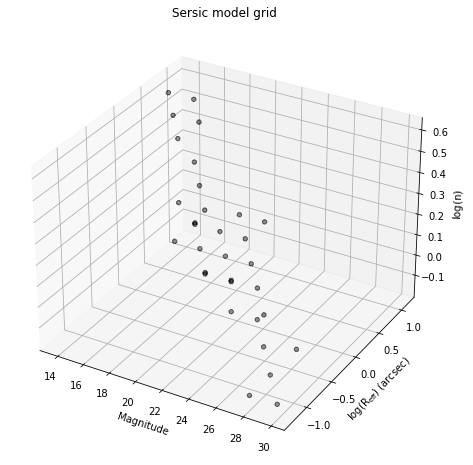

In [8]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')

x = initSersicTab['imagVar']
y = np.log10(initSersicTab['BulgeHalfLightRadius'])
z = np.log10(initSersicTab['bulge_n'])
ax.scatter(x, y, z, c='k', alpha=0.01)
ax.set_xlabel(r'Magnitude')
ax.set_ylabel(r'$\log($R$_{\rm eff}$) (arcsec)')
ax.set_zlabel(r'$\log($n$)$')
ax.set_title(r'Sersic model grid')

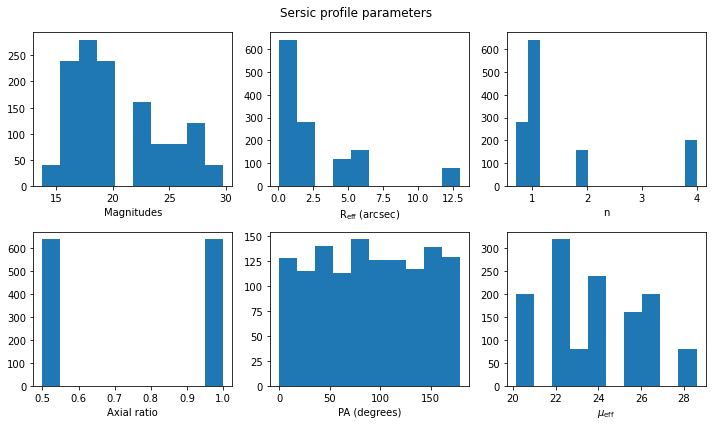

In [9]:
pm.plotParams(initSersicTab, r'Sersic profile parameters')

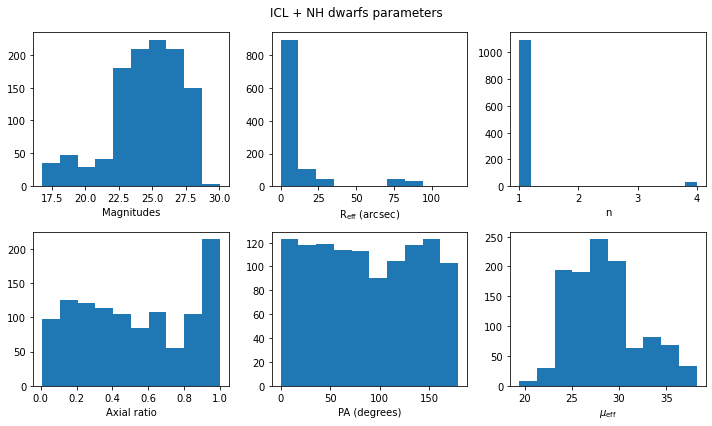

In [10]:
pm.plotParams(initIclTab, 'ICL + NH dwarfs parameters')

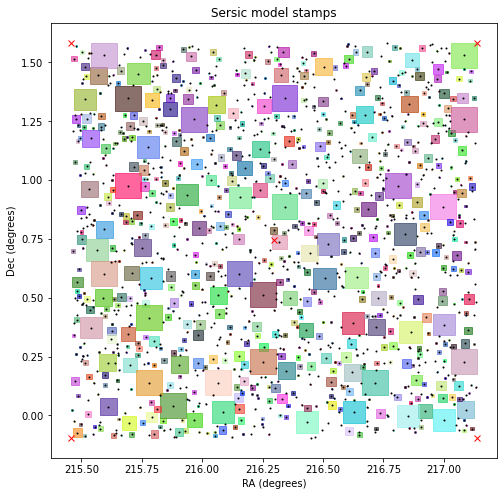

In [11]:
# Showing stamp distributions on the tract.  Allowed for 10% overlap between stamp boundaries.
# Red x's mark the tract center and vertices
pm.plotCoords(initSersicTab, butler, r'Sersic model stamps')

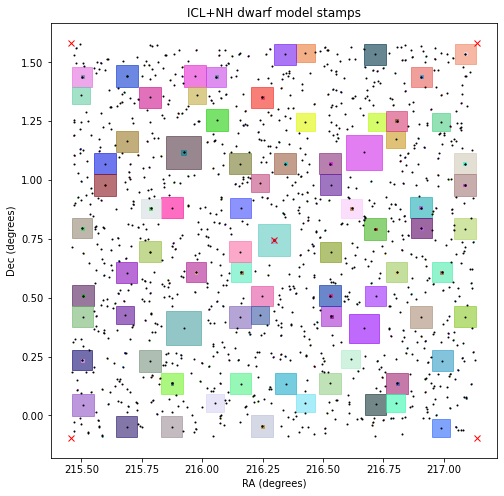

In [12]:
# ICL and dwarf models.
# Allowed for no overlap here.  ICL models sit in corners of patches.
# Typical dwarf stamp box size is smaller than the points.
pm.plotCoords(initIclTab, butler, r'ICL+NH dwarf model stamps')

Now we derive the necessary parameters for showing over-subtraction trends among the models.

This includes both what we call Delta-magnitude, the change in magnitude post-sky-subtraction, and a Delta-flux, the total loss of flux in the models post-sky-subtraction compared to the input values (gains in flux are ignored here).

We also derive model effective surface brightnesses, for constructing some of the detailed diagnostic plots that follow.

In [13]:
getFlux = lambda mag : 10**(-0.4*(mag - 27.0))

dMagSersic = outputSersicTab[band+'magVar'] - inputSersicTab[band+'magVar']
dFluxSersic = np.log10(getFlux(inputSersicTab[band+'magVar']) - getFlux(outputSersicTab[band+'magVar']))
dFperASersic = np.log10((getFlux(inputSersicTab[band+'magVar']) - getFlux(outputSersicTab[band+'magVar']))/
                        initSersicTab['stampWidth'][inputSersicTab['idx']]**2)
dMagIcl = outputIclTab[band+'magVar'] - inputIclTab[band+'magVar']
dFluxIcl = np.log10(getFlux(inputIclTab[band+'magVar']) - getFlux(outputIclTab[band+'magVar']))
dFperAIcl = np.log10((getFlux(inputIclTab[band+'magVar']) - getFlux(outputIclTab[band+'magVar']))/
                        initIclTab['stampWidth'][inputIclTab['idx']]**2)

muEffSersic, __ = ut.getMuEff(inputSersicTab[band+'magVar'], 
                              initSersicTab['BulgeHalfLightRadius'][inputSersicTab['idx']], 
                              initSersicTab['bulge_n'][inputSersicTab['idx']])
muEffIcl, __ = ut.getMuEff(inputIclTab[band+'magVar'], 
                           initIclTab['BulgeHalfLightRadius'][inputIclTab['idx']], 
                           initIclTab['bulge_n'][inputIclTab['idx']])

## Diagnostic 1: magnitude changes

In [14]:
yLims = [-2, 2]
yVarLab = r'$\Delta m$'
logrLab = r'$\log(R_{\rm eff}/{\rm arcsec})$'
nLab = r'n'
mueLab = r'$\mu_{\rm eff}$'
ellLab = r'b/a'
magLab = r'Magnitude'

### Sersic profiles

Text(0.5, 0, '$\\mu_{\\rm eff}$')

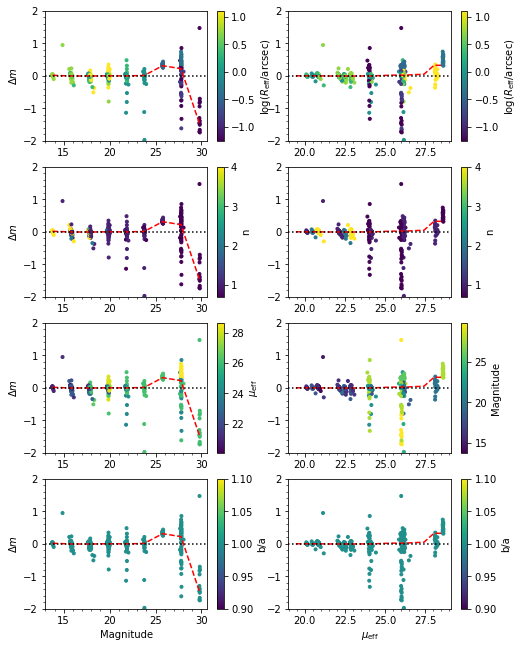

In [15]:
fig, ax = plt.subplots(4, 2, figsize=(8, 11))
# Magnitude vs. dMag
bufferMag = 1
zVarsMag = [np.log10(initSersicTab['BulgeHalfLightRadius'][inputSersicTab['idx']]),
            initSersicTab['bulge_n'][inputSersicTab['idx']],
            muEffSersic,
            initSersicTab['b_b'][inputSersicTab['idx']]]
zLabsMag = [logrLab, nLab, mueLab, ellLab]

for i in range(4):
    pm.scatterPlot(fig, ax[i,0], initSersicTab[band+'magVar'],
                   inputSersicTab[band+'magVar'], dMagSersic, 
                   zVarsMag[i], 
                   ~rejSersic, 
                   yLims, '', yVarLab, zLabsMag[i], buffer=bufferMag)
ax[3,0].set_xlabel(magLab)

# Mu_eff vs. dMag
bufferMu = 1
initMuEffSersic = ut.getMuEff(initSersicTab[band+'magVar'],
                              initSersicTab['BulgeHalfLightRadius'],
                              initSersicTab['bulge_n'])
zVarsMu = [np.log10(initSersicTab['BulgeHalfLightRadius'][inputSersicTab['idx']]),
           initSersicTab['bulge_n'][inputSersicTab['idx']],
           inputSersicTab[band+'magVar'],
           initSersicTab['b_b'][inputSersicTab['idx']]]
zLabsMu = [logrLab, nLab, magLab, ellLab]
for i in range(4):
    pm.scatterPlot(fig, ax[i,1], initMuEffSersic,
                   muEffSersic, dMagSersic, 
                   zVarsMu[i], 
                   ~rejSersic, 
                   yLims, '', '', zLabsMu[i], buffer=bufferMu)
ax[3,1].set_xlabel(mueLab)

Text(0.5, 0, 'n')

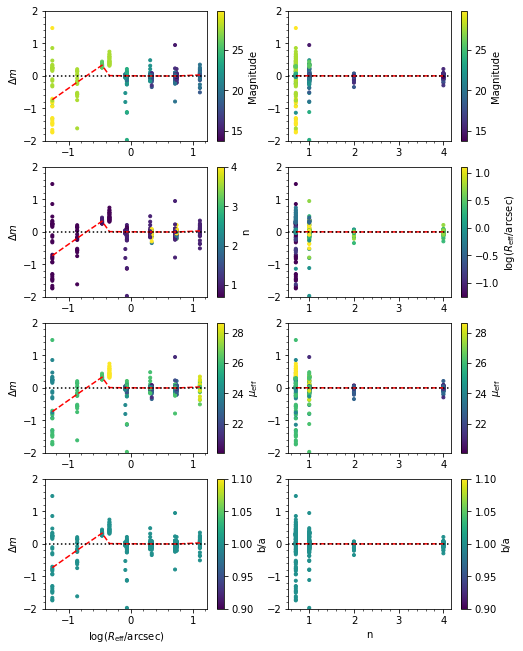

In [16]:
fig, ax = plt.subplots(4, 2, figsize=(8, 11))
# Reff vs. dMag
bufferReff = 0.3
zVarsReff = [inputSersicTab[band+'magVar'],
             initSersicTab['bulge_n'][inputSersicTab['idx']],
             muEffSersic,
             initSersicTab['b_b'][inputSersicTab['idx']]]
zLabsReff = [magLab, nLab, mueLab, ellLab]
for i in range(4):
    pm.scatterPlot(fig, ax[i,0], np.log10(initSersicTab['BulgeHalfLightRadius']),
                   np.log10(initSersicTab['BulgeHalfLightRadius'][inputSersicTab['idx']]), dMagSersic, 
                   zVarsReff[i], 
                   ~rejSersic, 
                   yLims, '', yVarLab, zLabsReff[i], buffer=bufferReff)
ax[3,0].set_xlabel(logrLab)

# n vs. dMag
bufferN = 0.5
zVarsN = [inputSersicTab[band+'magVar'],
          np.log10(initSersicTab['BulgeHalfLightRadius'][inputSersicTab['idx']]),
          muEffSersic,
          initSersicTab['b_b'][inputSersicTab['idx']]]
zLabsN = [magLab, logrLab, mueLab, ellLab]
for i in range(4):
    pm.scatterPlot(fig, ax[i,1], initSersicTab['bulge_n'],
                   initSersicTab['bulge_n'][inputSersicTab['idx']], dMagSersic, 
                   zVarsN[i], 
                   ~rejSersic, 
                   yLims, '', '', zLabsN[i], buffer=bufferN)
ax[3,1].set_xlabel(nLab)

In each of the above figures, we show the change in magnitude after sky-subtraction as a function of different model parameters, with various subplots color-coded by the other parameters not plotted.  Red dashed lines show the median trend, and the black dotted line shows 0 (no change).  Over-subtraction here is indicated by a positive value on the y-axis.

In general, we see mild over-subtraction for models with faint magnitudes and low effective surface brightnesses, excepting the very faintest models which show systematic under-subtraction (gaining flux).  The smallest effective radius models show under-subtraction as well, and there is no trend at all regarding surface brightness.  It is also worth noting that the scatter among magnitude changes for a given model type are often quite large, even for the brightest, highest surface brightness models.

The trend with effective radius, we should note, seems driven less by the effective radius itself and more by the correlation between effective radius and magnitude (fainter models are also smaller).  The two driving factors here thus seem to be magnitude and/or surface brightness.

A summary plot follows.

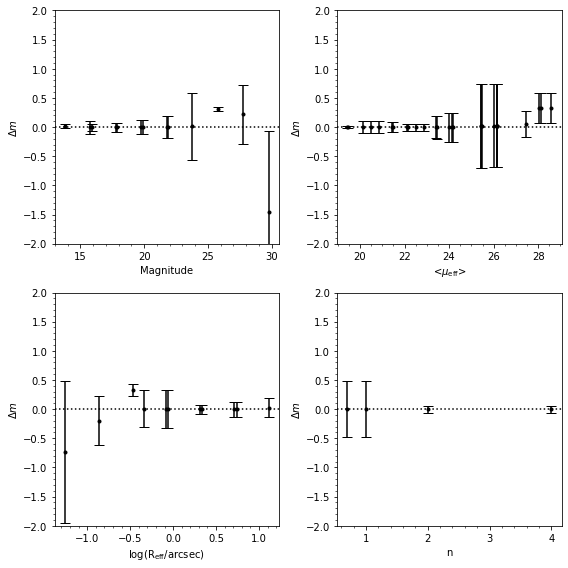

In [17]:
pm.plotMedsStds(initSersicTab, inputSersicTab, dMagSersic, initMuEffSersic, muEffSersic, ~rejSersic, 
                band, yLims, yVarLab)

### New Horizon dwarfs & ICL

Text(0.5, 0, '$\\mu_{\\rm eff}$')

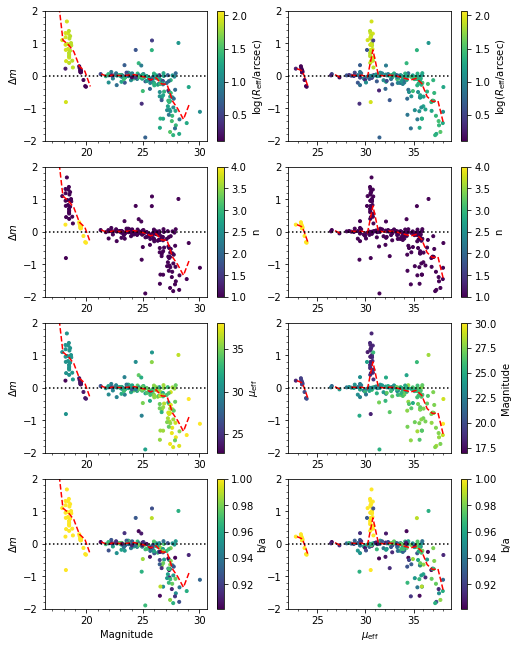

In [18]:
fig, ax = plt.subplots(4, 2, figsize=(8, 11))
# Magnitude vs. dMag
nBinsMag = 30
bufferMag = 1
zVarsMag = [np.log10(initIclTab['BulgeHalfLightRadius'][inputIclTab['idx']]),
            initIclTab['bulge_n'][inputIclTab['idx']],
            muEffIcl,
            initIclTab['b_b'][inputIclTab['idx']]]
zLabsMag = [logrLab, nLab, mueLab, ellLab]
for i in range(4):
    pm.scatterPlotIcl(fig, ax[i,0],
                   inputIclTab[band+'magVar'], dMagIcl,
                   zVarsMag[i], 
                   ~rejIcl, 
                   yLims, '', yVarLab, zLabsMag[i], nBins=nBinsMag, buffer=bufferMag)
ax[3,0].set_xlabel(magLab)

# Mu_eff vs. dMag
nBinsMu = 30
bufferMu = 1
zVarsMu = [np.log10(initIclTab['BulgeHalfLightRadius'][inputIclTab['idx']]),
           initIclTab['bulge_n'][inputIclTab['idx']],
           inputIclTab[band+'magVar'],
           initIclTab['b_b'][inputIclTab['idx']]]
zLabsMu = [logrLab, nLab, magLab, ellLab]
for i in range(4):
    pm.scatterPlotIcl(fig, ax[i,1],
                      muEffIcl, dMagIcl, 
                      zVarsMu[i], 
                      ~rejIcl, 
                      yLims, '', '', zLabsMu[i], nBins=nBinsMu, buffer=bufferMu)
ax[3,1].set_xlabel(mueLab)

Text(0.5, 0, 'n')

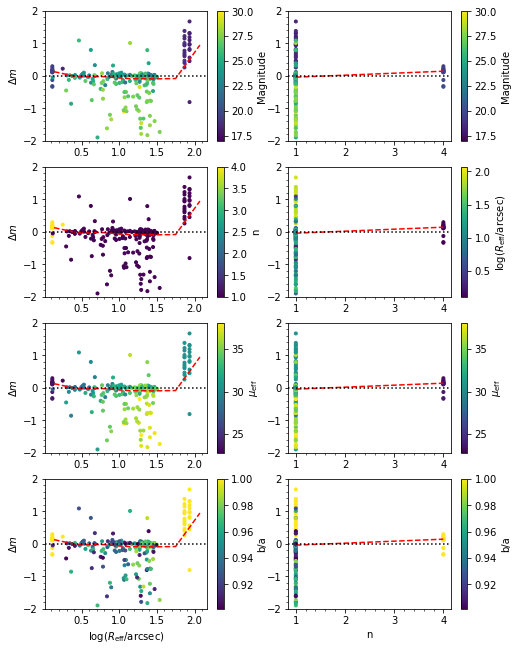

In [19]:
fig, ax = plt.subplots(4, 2, figsize=(8, 11))
# Reff vs. dMag
nBinsReff = 8
bufferReff = 0.3
zVarsReff = [inputIclTab[band+'magVar'],
             initIclTab['bulge_n'][inputIclTab['idx']],
             muEffIcl,
             initIclTab['b_b'][inputIclTab['idx']]]
zLabsReff = [magLab, nLab, mueLab, ellLab]
for i in range(4):
    pm.scatterPlotIcl(fig, ax[i,0],
                   np.log10(initIclTab['BulgeHalfLightRadius'][inputIclTab['idx']]), dMagIcl, 
                   zVarsReff[i], 
                   ~rejIcl, 
                   yLims, '', yVarLab, zLabsReff[i], nBins=nBinsReff, buffer=bufferReff)
ax[3,0].set_xlabel(logrLab)

# n vs. dMag
bufferN = 0.5
zVarsN = [inputIclTab[band+'magVar'],
          np.log10(initIclTab['BulgeHalfLightRadius'][inputIclTab['idx']]),
          muEffIcl,
          initIclTab['b_b'][inputIclTab['idx']]]
zLabsN = [magLab, logrLab, mueLab, ellLab]
for i in range(4):
    pm.scatterPlot(fig, ax[i,1], initIclTab['bulge_n'],
                   initIclTab['bulge_n'][inputIclTab['idx']], dMagIcl, 
                   zVarsN[i], 
                   ~rejIcl, 
                   yLims, '', '', zLabsN[i], buffer=bufferN)
ax[3,1].set_xlabel(nLab)

The trends uncovered here are very similar: little change in magnitude up until the faintest, lowest surface brightness models, which seem to be systematically undersubtracted.  Size and surface brightness, however, begin to dominate for the ICL profiles (these are the cluster of large effective radius, low surface brightness objects), which show systematic over-subtraction by ~1 magnitude on average. In the next section, we explore this behavior in more depth.

A summary plot is show below.

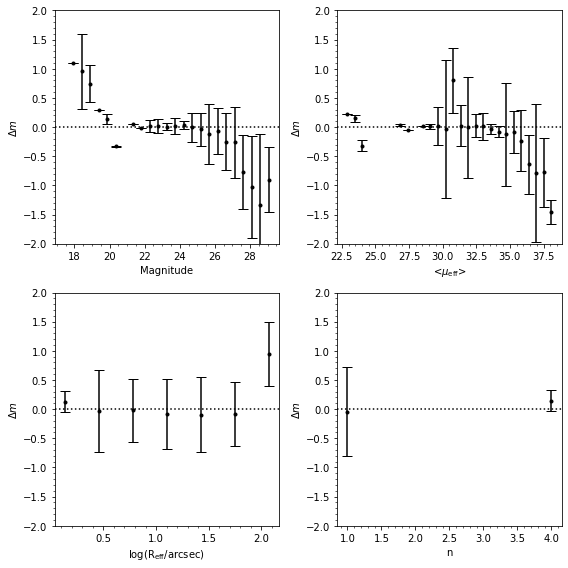

In [20]:
pm.plotMedsStdsIcl(initIclTab, inputIclTab, dMagIcl, muEffIcl, ~rejIcl, band, yLims, yVarLab)

## Diagnostic 2: changes to surface brightness profiles

Here we take the measured surface brightness profiles for each Sersic model and compare them pre- and post-sky-subtraction.  We do this by finding the surface brightnesses (in the pre-sky-subtraction profiles) at which every profile is over-subtracted by 0.1 magnitudes/arcsec^2, which gives us a feel for the current HSC limiting surface brightness as determined by the sky over-subtraction (0.1 is approximately a 10% difference, though we might strive for better than 10% accuracy).

We exclude the ICL models from this analysis, as these typically have central surface brightnesses below 28, hence skew the results heavily.

Text(0.5, 1.0, 'NH Dwarfs')

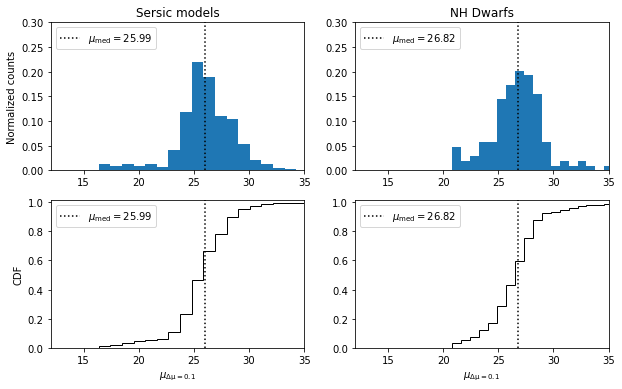

In [21]:
# Ignoring ICL, which has profiles that start below 28 typically
rejIcl2 = rejIcl | (initIclTab['BulgeHalfLightRadius'][inputIclTab['idx']] >= 20)
fig, ax = plt.subplots(2, 2, figsize=(10,6))
dMu = 0.1
pm.plotSBHists(ax[0,0], inputSersicTab, outputSersicTab, rejSersic, band, dMu)
pm.plotSBHists(ax[0,1], inputIclTab, outputIclTab, rejIcl2, band, dMu)
pm.plotSBHists(ax[1,0], inputSersicTab, outputSersicTab, rejSersic, band, dMu, False)
pm.plotSBHists(ax[1,1], inputIclTab, outputIclTab, rejIcl2, band, dMu, False)
ax[0,0].set_ylabel(r'Normalized counts')
ax[1,0].set_ylabel(r'CDF')
ax[1,0].set_xlabel(r'$\mu_{\rm \Delta \mu = %.1f}$'%(dMu))
ax[1,1].set_xlabel(r'$\mu_{\rm \Delta \mu = %.1f}$'%(dMu))

ax[0,0].set_title('Sersic models')
ax[0,1].set_title('NH Dwarfs')

From this, we glean that on average the profiles start becoming seriously over-subtracted by around \~26 -- 27 magnitudes/arcsec^2, with a large scatter (\~2 mags/arcsec^2).  There may be a second peak for bright models, at around 19, which doesn't occur for the NH models due to a lack of such models in that parameter space.  The difference in median values between the Sersic and NH distributions is due to the differences in model types: the NH models are lower in surface brightness on average than the Sersic models, hence the distribution is skewed to the right by models with central surface brightnesses already lower than 26.

We can test this behavior further by taking different limits on the oversubtraction besides just 0.1--what is the typical surface brightness at which the profiles are over-subtracted by 0.2 mags/arcsec^2?  0.3?  0.5?  1.0?  We show this below.

In [22]:
# Checking the median SB at which profile is over-subtracted by a range of amounts
sbLims = np.arange(0.1, 5.1, 0.1)

medsSersic = np.zeros(len(sbLims))
stdsSersic = np.zeros(len(sbLims))
N = np.zeros(len(sbLims))
for i in range(len(sbLims)):
    sbSubSersic = pm.sbOverSub(inputSersicTab[~rejSersic], outputSersicTab[~rejSersic], band, sbLims[i])
    medsSersic[i] = np.nanmedian(sbSubSersic[np.isfinite(sbSubSersic)])
    stdsSersic[i] = np.nanstd(sbSubSersic[np.isfinite(sbSubSersic)])
    N[i] = len(sbSubSersic[np.isfinite(sbSubSersic)])
    
medsIcl = np.zeros(len(sbLims))
stdsIcl = np.zeros(len(sbLims))
for i in range(len(sbLims)):
    sbSubIcl = pm.sbOverSub(inputIclTab[~rejIcl2], outputIclTab[~rejIcl2], band, sbLims[i])
    medsIcl[i] = np.nanmedian(sbSubIcl[np.isfinite(sbSubIcl)])
    stdsIcl[i] = np.nanstd(sbSubIcl[np.isfinite(sbSubIcl)])

In [23]:
# Picking an SB value for scientific illustration purposes
from scipy.interpolate import interp1d
fSersic = interp1d(sbLims, medsSersic)
highRes = np.arange(0.1, 5.01, 0.01)
medsSersicHR = fSersic(highRes)
idxDwSersic = np.where(np.isclose(medsSersicHR, 28.0, atol=0.01))[0][0]

fIcl = interp1d(sbLims, medsIcl)
medsIclHR = fIcl(highRes)
idxDwIcl = np.where(np.isclose(medsIclHR, 28.0, atol=0.01))[0][0]

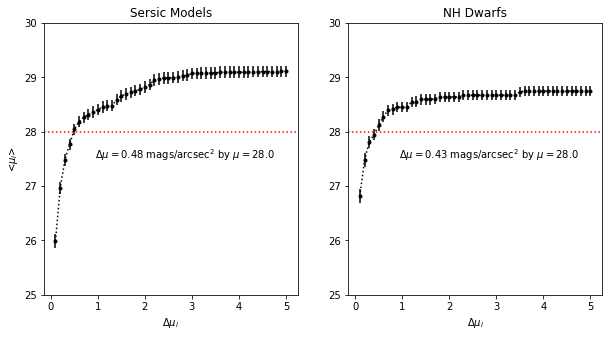

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
# Using standard error on the median as the error bar lengths
ax[0].errorbar(sbLims, medsSersic, yerr=1.2*stdsSersic/np.sqrt(N), marker='.', c='k', linestyle=':')
ax[0].axhline(medsSersicHR[idxDwSersic], c='r', linestyle=':')
ax[0].annotate(r'$\Delta \mu = $%.2f mags/arcsec$^{2}$ by $\mu = 28.0$'%(highRes[idxDwSersic]), 
              xy=(0.2, 0.5), xycoords='axes fraction')
ax[0].set_xlabel(r'$\Delta \mu_{'+band+'}$')
ax[0].set_ylabel(r'<$\mu_{'+band+'}$>')
ax[0].set_title(r"Sersic Models")

ax[1].errorbar(sbLims, medsIcl, yerr=1.2*stdsIcl/np.sqrt(N), marker='.', c='k', linestyle=':')
ax[1].axhline(medsIclHR[idxDwIcl], c='r', linestyle=':')
ax[1].annotate(r'$\Delta \mu = $%.2f mags/arcsec$^{2}$ by $\mu = 28.0$'%(highRes[idxDwIcl]), 
              xy=(0.2, 0.5), xycoords='axes fraction')
ax[1].set_xlabel(r'$\Delta \mu_{'+band+'}$')
ax[1].set_title(r'NH Dwarfs')
for i in range(2):
    ax[i].set_ylim([25, 30])

The behavior here is quite regular--we see a sharp rise in the amount of flux over-subtraction toward fainter and fainter surface brightnesses, with asymptotic behavior.  By only 29 mags/arcsec^2, profiles are being over-subtracted systematically by more than 1 mag/arcsec^2, and no profiles seem to survive beyond around 29 in both sets of models. We show specifically the effect at 28 mag/arcsec^2, which is roughly the surface brightness regime of z=0.3 ICL and low-mass dwarf galaxies.

This suggests that the problem of dark rings surrounding extended objects (as noted previously in HSC PDR1; see Fig. 5 of [Aihara et al. 2019](https://ui.adsabs.harvard.edu/abs/2019PASJ...71..114A/abstract)) still exists, albeit at lower surface brightness than before.  Indeed, we can see such dark rings in the images themselves once the noise and astrophysical flux has been subtracted out.  We show this below for two different models.

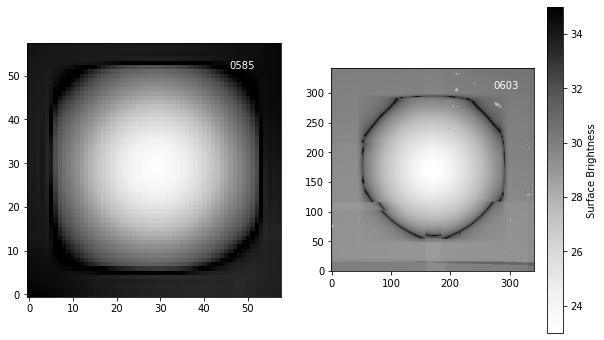

In [25]:
import image_retrieval as imret
idx = [585, 603]
fig, ax = plt.subplots(1, 2, figsize=(10, 6))

for i,j in enumerate(idx):
    coaddNoFake, magZp = imret.getCoaddCutout(initSersicTab['raJ2000'][j], 
                                       initSersicTab['decJ2000'][j], 
                                       initSersicTab['stampWidth'][j], 
                                       butler, band, 'deepCoadd', tract)
    coaddFake, magZp = imret.getCoaddCutout(initSersicTab['raJ2000'][j], 
                                     initSersicTab['decJ2000'][j], 
                                     initSersicTab['stampWidth'][j], 
                                     butler_fk, band, 'fakes_deepCoadd', tract)
    diffImCoadd = coaddFake - coaddNoFake
    lgimCoadd = ut.mkLogIm(diffImCoadd)
    im = ax[i].imshow(-2.5*lgimCoadd+27.0+2.5*np.log10(0.168**2), origin='lower',
                      vmin = 23, vmax = 35, cmap='Greys')
    ax[i].annotate(initSersicTab['modelId'][j], xy=(0.8, 0.9), xycoords='axes fraction', color='white')
cb = fig.colorbar(im, ax=ax[1])
cb.set_label('Surface Brightness')

Images are scaled to units of surface brightness.  Dark rings surround each of these models, which should not be present for single Sersic component models.  (We note that the choppy appearance of the larger model on the right is seemingly due to the dithering pattern--the S/N in different parts of the tract changes based on this, yielding systematically brighter and fainter regions.  A revised dither pattern should fix this particular issue.)

Regardless, this behavior seems to explain the behavior of the magnitude changes shown above--models with more of their flux at low surface brightnesses lose a larger fraction of their total flux than otherwise.  Bright, high surface brightness objects show little magnitude change on average, while faint, low surface brightness objects show large changes in magnitude (although this does not explain why the faintest models GAIN flux; potentially, this implies that the sky estimate in regions free of contamination--or in this case, where the models are too small and faint to have significant impact on the local sky--are too faint).  Given this, we finish our analysis by examining the total flux lost in each model, rather than changes in magnitude or surface brightness.

## Diagnostic 3: total flux lost

### Sersic profiles

In [26]:
yLims = [-3, 5]
yVarLab = r'$\log(\Delta$F)'
areaLab = r'$\log(\Delta{\rm F}/{\rm Area})$'

Text(0.5, 0, '$\\mu_{\\rm eff}$')

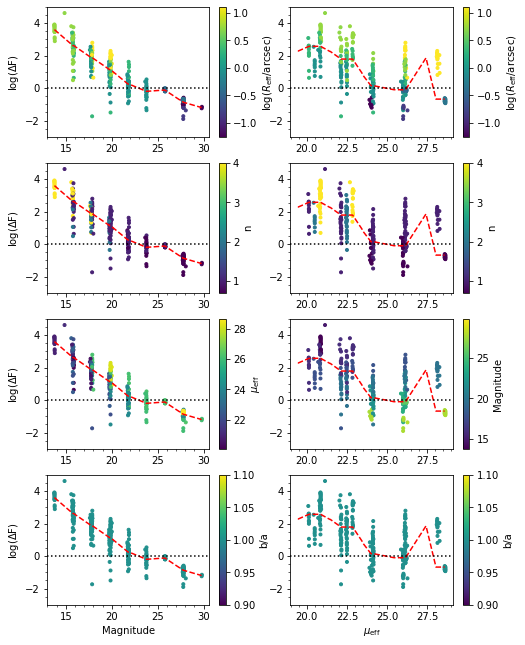

In [27]:
fig, ax = plt.subplots(4, 2, figsize=(8, 11))
# Magnitude vs. dFlux
bufferMag = 1
zVarsMag = [np.log10(initSersicTab['BulgeHalfLightRadius'][inputSersicTab['idx']]),
            initSersicTab['bulge_n'][inputSersicTab['idx']],
            muEffSersic,
            initSersicTab['b_b'][inputSersicTab['idx']]]
zLabsMag = [logrLab, nLab, mueLab, ellLab]

for i in range(4):
    pm.scatterPlot(fig, ax[i,0], initSersicTab[band+'magVar'],
                   inputSersicTab[band+'magVar'], dFluxSersic, 
                   zVarsMag[i], 
                   ~rejSersic, 
                   yLims, '', yVarLab, zLabsMag[i], buffer=bufferMag)
ax[3,0].set_xlabel(magLab)

# Mu_eff vs. dMag
bufferMu = 1
initMuEffSersic = ut.getMuEff(initSersicTab[band+'magVar'],
                              initSersicTab['BulgeHalfLightRadius'],
                              initSersicTab['bulge_n'])
zVarsMu = [np.log10(initSersicTab['BulgeHalfLightRadius'][inputSersicTab['idx']]),
           initSersicTab['bulge_n'][inputSersicTab['idx']],
           inputSersicTab[band+'magVar'],
           initSersicTab['b_b'][inputSersicTab['idx']]]
zLabsMu = [logrLab, nLab, magLab, ellLab]
for i in range(4):
    pm.scatterPlot(fig, ax[i,1], initMuEffSersic,
                   muEffSersic, dFluxSersic, 
                   zVarsMu[i], 
                   ~rejSersic, 
                   yLims, '', '', zLabsMu[i], buffer=bufferMu)
ax[3,1].set_xlabel(mueLab)

Text(0.5, 0, 'n')

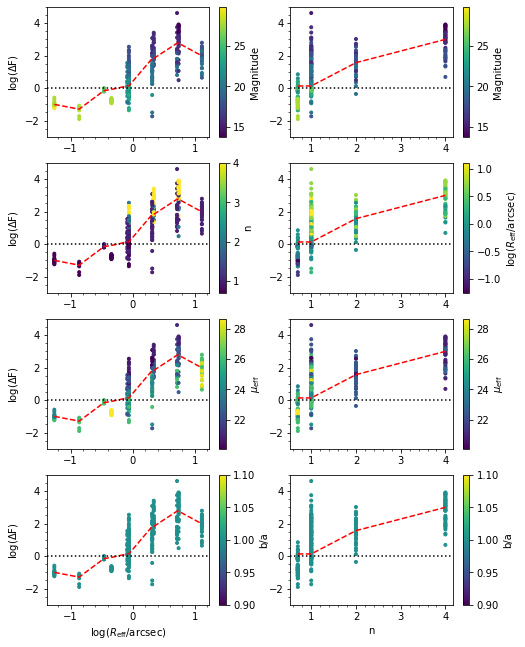

In [28]:
fig, ax = plt.subplots(4, 2, figsize=(8, 11))
# Reff vs. dMag
bufferReff = 0.3
zVarsReff = [inputSersicTab[band+'magVar'],
             initSersicTab['bulge_n'][inputSersicTab['idx']],
             muEffSersic,
             initSersicTab['b_b'][inputSersicTab['idx']]]
zLabsReff = [magLab, nLab, mueLab, ellLab]
for i in range(4):
    pm.scatterPlot(fig, ax[i,0], np.log10(initSersicTab['BulgeHalfLightRadius']),
                   np.log10(initSersicTab['BulgeHalfLightRadius'][inputSersicTab['idx']]), dFluxSersic, 
                   zVarsReff[i], 
                   ~rejSersic, 
                   yLims, '', yVarLab, zLabsReff[i], buffer=bufferReff)
ax[3,0].set_xlabel(logrLab)

# n vs. dMag
bufferN = 0.5
zVarsN = [inputSersicTab[band+'magVar'],
          np.log10(initSersicTab['BulgeHalfLightRadius'][inputSersicTab['idx']]),
          muEffSersic,
          initSersicTab['b_b'][inputSersicTab['idx']]]
zLabsN = [magLab, logrLab, mueLab, ellLab]
for i in range(4):
    pm.scatterPlot(fig, ax[i,1], initSersicTab['bulge_n'],
                   initSersicTab['bulge_n'][inputSersicTab['idx']], dFluxSersic, 
                   zVarsN[i], 
                   ~rejSersic, 
                   yLims, '', '', zLabsN[i], buffer=bufferN)
ax[3,1].set_xlabel(nLab)

The behavior here is quite regular and easily explained: bright objects (which are large, high in Sersic index, and have high surface brightnesses) lose more total flux than faint objects (which are small, low in Sersic index, and have low surface brightnesses).  So while the total *fraction* of flux lost is smallest for brighter, more centrally concentrated objects, the total *amount* of flux lost is highest for such objects.  The sky subtraction thus seems simply to be removing flux in proportion (as a power law) to the brightnesses of the models.

A summary plot follows.

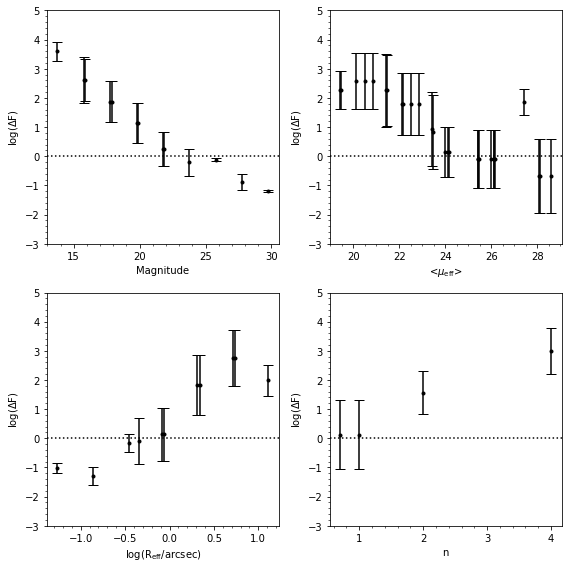

In [29]:
pm.plotMedsStds(initSersicTab, inputSersicTab, dFluxSersic, initMuEffSersic, muEffSersic, ~rejSersic, 
                band, yLims, yVarLab)

It is also worth showing the flux lost per pixel, so we include this below.

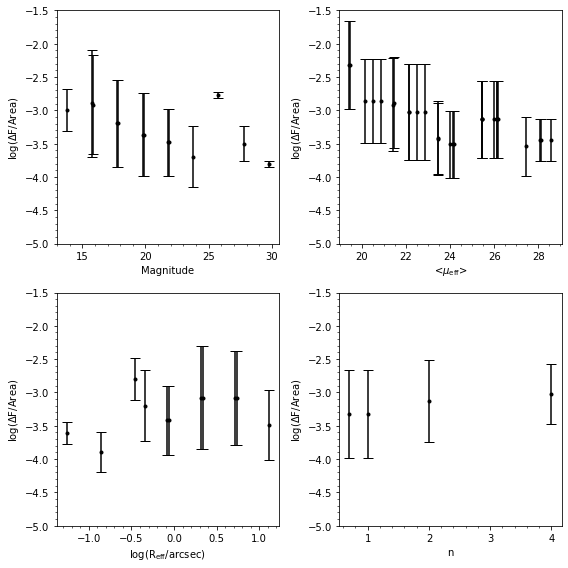

In [30]:
pm.plotMedsStds(initSersicTab, inputSersicTab, dFperASersic, initMuEffSersic, muEffSersic, ~rejSersic, 
                band, [-5, -1.5], areaLab)

Clearly, the larger galaxies are losing not just more flux, but more flux per unit area, indicating that the local sky estimation is worse for brighter objects than it is for fainter objects.  So while the magnitudes are changing more for fainter objects, the amount of flux lost is more for brighter objects even when taking their larger sizes into account.

### ICL + NH dwarfs

Text(0.5, 0, '$\\mu_{\\rm eff}$')

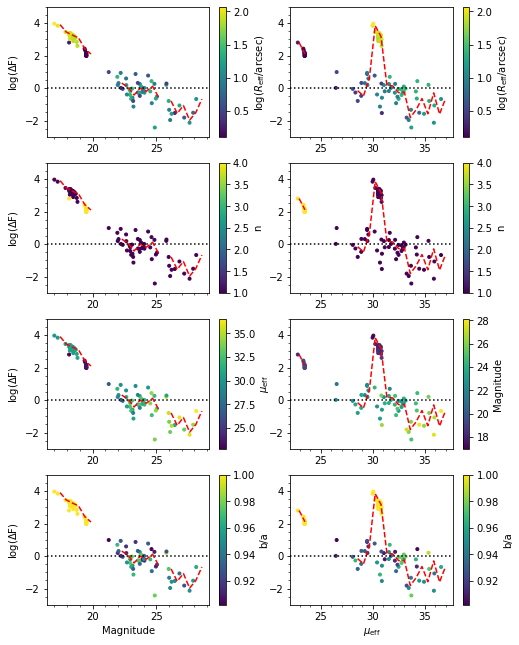

In [31]:
fig, ax = plt.subplots(4, 2, figsize=(8, 11))
# Magnitude vs. dMag
nBinsMag = 30
bufferMag = 1
zVarsMag = [np.log10(initIclTab['BulgeHalfLightRadius'][inputIclTab['idx']]),
            initIclTab['bulge_n'][inputIclTab['idx']],
            muEffIcl,
            initIclTab['b_b'][inputIclTab['idx']]]
zLabsMag = [logrLab, nLab, mueLab, ellLab]
for i in range(4):
    pm.scatterPlotIcl(fig, ax[i,0],
                   inputIclTab[band+'magVar'], dFluxIcl,
                   zVarsMag[i], 
                   ~rejIcl, 
                   yLims, '', yVarLab, zLabsMag[i], nBins=nBinsMag, buffer=bufferMag)
ax[3,0].set_xlabel(magLab)

# Mu_eff vs. dMag
nBinsMu = 30
bufferMu = 1
zVarsMu = [np.log10(initIclTab['BulgeHalfLightRadius'][inputIclTab['idx']]),
           initIclTab['bulge_n'][inputIclTab['idx']],
           inputIclTab[band+'magVar'],
           initIclTab['b_b'][inputIclTab['idx']]]
zLabsMu = [logrLab, nLab, magLab, ellLab]
for i in range(4):
    pm.scatterPlotIcl(fig, ax[i,1],
                   muEffIcl, dFluxIcl, 
                   zVarsMu[i], 
                   ~rejIcl, 
                   yLims, '', '', zLabsMu[i], nBins=nBinsMu, buffer=bufferMu)
ax[3,1].set_xlabel(mueLab)

Text(0.5, 0, 'n')

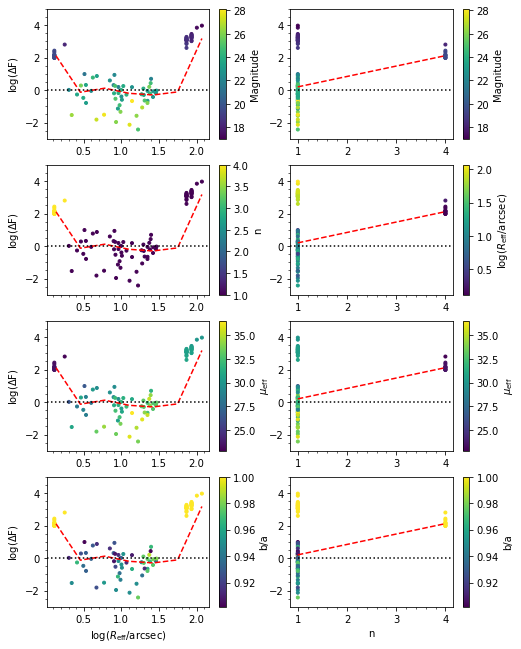

In [32]:
fig, ax = plt.subplots(4, 2, figsize=(8, 11))
# Reff vs. dMag
nBinsReff = 8
bufferReff = 0.3
zVarsReff = [inputIclTab[band+'magVar'],
             initIclTab['bulge_n'][inputIclTab['idx']],
             muEffIcl,
             initIclTab['b_b'][inputIclTab['idx']]]
zLabsReff = [magLab, nLab, mueLab, ellLab]
for i in range(4):
    pm.scatterPlotIcl(fig, ax[i,0],
                   np.log10(initIclTab['BulgeHalfLightRadius'][inputIclTab['idx']]), dFluxIcl, 
                   zVarsReff[i], 
                   ~rejIcl, 
                   yLims, '', yVarLab, zLabsReff[i], nBins=nBinsReff, buffer=bufferReff)
ax[3,0].set_xlabel(logrLab)

# n vs. dMag
bufferN = 0.5
zVarsN = [inputIclTab[band+'magVar'],
          np.log10(initIclTab['BulgeHalfLightRadius'][inputIclTab['idx']]),
          muEffIcl,
          initIclTab['b_b'][inputIclTab['idx']]]
zLabsN = [magLab, logrLab, mueLab, ellLab]
for i in range(4):
    pm.scatterPlot(fig, ax[i,1], initIclTab['bulge_n'],
                   initIclTab['bulge_n'][inputIclTab['idx']], dFluxIcl, 
                   zVarsN[i], 
                   ~rejIcl, 
                   yLims, '', '', zLabsN[i], buffer=bufferN)
ax[3,1].set_xlabel(nLab)

The same behavior is seen with these models as well.  A summary plot follows.

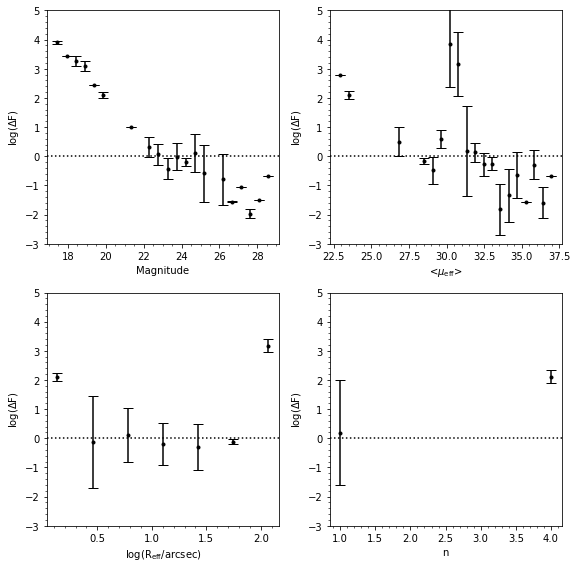

In [33]:
pm.plotMedsStdsIcl(initIclTab, inputIclTab, dFluxIcl, muEffIcl, ~rejIcl, band, yLims, yVarLab)

And again, showing the flux lost per unit area.

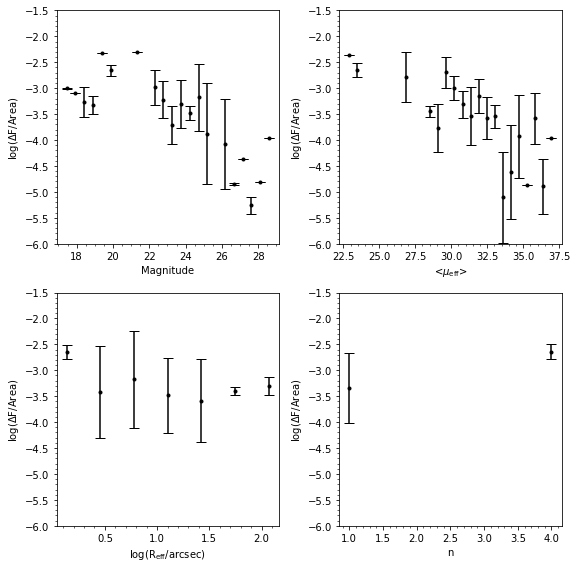

In [34]:
pm.plotMedsStdsIcl(initIclTab, inputIclTab, dFperAIcl, muEffIcl, ~rejIcl, band, [-6, -1.5], areaLab)

We saw this before regarding the final sky subtraction step (accessible as `deepCoadd_calexp` from the Butler), so evidently some kind of mesh-based approach to sky estimation is being used here as well, and is having a similar kind of detrimental effect on extended objects (though not nearly as severe as it is for that case).  Two solutions for this issue come to mind:

 1. Better masking--if the wings of bright objects are properly masked, that flux will not be incorporated so readily into the local sky estimation around those objects
 2. Don't use a mesh-based approach--a full-focal-plane sky subtraction utilizing a model that covers the entire focal plane, rather than this more localized box-based estimation, would be less susceptible to being altered locally by bright objects
 
The latter approach is the more difficult one to implement, but would be the best option for solving the problem--any amount of LSB flux that isn't masked would be incorporated at some level into the local sky estimation, so a solution that avoids relying on such masks is ideal.  I note that I am currently working on a feasible full-focal-plane sky subtraction approach that doesn't rely heavily on mathematical modeling, which could be implemented into the pipeline at a future date.

## Summary

The current sky-subtraction algorithm appears to be removing significant flux below around 26 magnitudes/arcsec^2 for extended objects (on average).  This results in significant flux loss around bright and faint objects alike, although the total magnitudes of faint objects are being affected more than those of bright objects since more of their total flux lies below this surface brightness.  The absolute faintest objects, however, are somehow *gaining* flux systematically, possibly hinting that the sky estimates in regions free of noticeable extended sources are too low.  These are also general trends: the scatter, in all cases, is significant.  Magnitudes and surface brightnesses are currently uncomfortably unreliable for extended objects when processed through the current pipeline.

This present a serious problem for galaxies science generally, and for low surface brightness science in particular.  The issue seems to be related to the current mesh-based sky modeling approach; if so, it might be alleviated through better masking of the wings of extended objects, or else by eschewing the mesh-based approach for a more general full-focal-plane modeling approach that is less sensitive to the wings of extended objects.